In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor



In [133]:
df = pd.read_csv("Final_OG.csv")

In [134]:
df['Strat_cat']=df['EF']+"_"+df['Shell']
df.drop(['EF','Shell'],axis=1,inplace=True)

In [135]:
df

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,Rx,Ry,a/h,Skew_Angle,Poisson_R,Omega,Strat_cat
0,15.0,4,10.0,0.0,0.0,0.0,0.0,5.0,0.0,0.25,8.5824,EF0_Plate
1,15.0,4,10.0,0.0,0.0,0.0,0.0,5.0,15.0,0.25,8.7210,EF0_Plate
2,15.0,4,10.0,0.0,0.0,0.0,0.0,5.0,30.0,0.25,9.5835,EF0_Plate
3,15.0,4,10.0,0.0,0.0,0.0,0.0,5.0,45.0,0.25,11.7615,EF0_Plate
4,15.0,4,10.0,0.0,0.0,0.0,0.0,5.0,60.0,0.25,13.1818,EF0_Plate
...,...,...,...,...,...,...,...,...,...,...,...,...
732525,90.0,8,40.0,10000.0,10000.0,1.0,1.0,50.0,75.0,0.40,208.7591,EF3_Spherical
732526,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,0.0,0.40,356.8233,EF3_Spherical
732527,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,15.0,0.40,376.6690,EF3_Spherical
732528,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,45.0,0.40,386.4073,EF3_Spherical


In [136]:
# Shell Mask

sph_shell = (df['Rx'] > 0) & (df['Ry'] > 0)
cyl_shell = (df['Rx'] > 0) & (df['Ry'] == 0)
saddl_shell = (df['Rx'] > 0) & (df['Ry'] < 0)
plate_shell = (df['Rx'] == 0) & (df['Ry'] == 0)

In [137]:
sph = df[sph_shell]
cyl = df[cyl_shell]
saddl = df[saddl_shell]
plate = df[plate_shell]

In [167]:
mask = (df['Winkler'] == 0) | (df['Pasternak'] <= 25) 

In [168]:
group_a = sph[mask]  
group_b = sph[~mask] 

C:\Users\Sabyasachi\AppData\Local\Temp\ipykernel_16324\855982413.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_a = sph[mask]
C:\Users\Sabyasachi\AppData\Local\Temp\ipykernel_16324\855982413.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_b = sph[~mask]


In [173]:
n_samples_a = int(len(group_a) * 0.025)

# Randomly sample from Group A
sampled_group_a = group_a.groupby('Strat_cat').sample(n=n_samples_a, random_state=42)
sampled_group_a

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,Rx,Ry,a/h,Skew_Angle,Poisson_R,Omega,Strat_cat
597636,15.0,14,5.0,0.0,0.0,0.80,0.80,10.0,30.0,0.25,15.0626,EF0_Spherical
615095,75.0,4,5.0,0.0,0.0,1.00,1.00,100.0,45.0,0.25,118.7257,EF0_Spherical
644839,60.0,12,90.0,0.0,0.0,0.10,0.10,5.0,60.0,0.25,24.7868,EF0_Spherical
612254,60.0,10,10.0,0.0,0.0,0.80,0.80,10.0,60.0,0.25,27.0500,EF0_Spherical
615177,75.0,4,10.0,0.0,0.0,0.25,0.25,100.0,15.0,0.25,38.2734,EF0_Spherical
...,...,...,...,...,...,...,...,...,...,...,...,...
372577,15.0,4,40.0,100.0,5.0,1.00,1.00,10.0,30.0,0.25,30.9771,EF3_Spherical
717178,15.0,8,40.0,500.0,10.0,0.10,0.10,100.0,0.0,0.40,37.9128,EF3_Spherical
387976,30.0,8,25.0,500.0,10.0,0.50,0.50,10.0,15.0,0.25,33.1726,EF3_Spherical
713130,15.0,4,40.0,500.0,10.0,1.00,1.00,50.0,0.0,0.20,91.2520,EF3_Spherical


In [174]:
group_b

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,Rx,Ry,a/h,Skew_Angle,Poisson_R,Omega,Strat_cat
370670,15.0,4,10.0,500.0,50.0,0.1,0.1,5.0,0.0,0.25,32.4782,EF3_Spherical
370671,15.0,4,10.0,500.0,50.0,0.1,0.1,5.0,15.0,0.25,31.3533,EF3_Spherical
370672,15.0,4,10.0,500.0,50.0,0.1,0.1,5.0,30.0,0.25,30.2056,EF3_Spherical
370673,15.0,4,10.0,500.0,50.0,0.1,0.1,5.0,45.0,0.25,29.3561,EF3_Spherical
370674,15.0,4,10.0,500.0,50.0,0.1,0.1,5.0,60.0,0.25,28.7375,EF3_Spherical
...,...,...,...,...,...,...,...,...,...,...,...,...
732525,90.0,8,40.0,10000.0,10000.0,1.0,1.0,50.0,75.0,0.40,208.7591,EF3_Spherical
732526,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,0.0,0.40,356.8233,EF3_Spherical
732527,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,15.0,0.40,376.6690,EF3_Spherical
732528,90.0,8,40.0,10000.0,10000.0,1.0,1.0,100.0,45.0,0.40,386.4073,EF3_Spherical


In [175]:
n_samples_b = 150000 - len(sampled_group_a)

# Sample from Group B
sampled_group_b = group_b.groupby('Strat_cat').sample(n=min(n_samples_b, len(group_b)), random_state=42)
sampled_group_b

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,Rx,Ry,a/h,Skew_Angle,Poisson_R,Omega,Strat_cat
716472,15.0,8,40.0,500.0,100.0,0.40,0.40,100.0,45.0,0.30,130.7924,EF3_Spherical
408734,60.0,12,40.0,2500.0,100.0,0.50,0.50,5.0,60.0,0.25,57.3670,EF3_Spherical
409057,60.0,12,40.0,7500.0,2500.0,1.00,1.00,10.0,30.0,0.25,105.8991,EF3_Spherical
419925,75.0,12,25.0,1000.0,100.0,1.00,1.00,100.0,0.0,0.25,152.1902,EF3_Spherical
723414,60.0,4,40.0,7500.0,7500.0,0.10,0.10,50.0,0.0,0.20,292.0319,EF3_Spherical
...,...,...,...,...,...,...,...,...,...,...,...,...
719314,45.0,4,40.0,7500.0,5000.0,0.75,0.75,100.0,0.0,0.30,414.7224,EF3_Spherical
731997,90.0,8,40.0,500.0,100.0,1.00,1.00,50.0,75.0,0.40,108.5812,EF3_Spherical
420348,75.0,12,25.0,7500.0,5000.0,1.00,1.00,100.0,45.0,0.25,385.4802,EF3_Spherical
371770,15.0,4,25.0,500.0,100.0,0.50,0.50,5.0,0.0,0.25,39.4572,EF3_Spherical


In [176]:
balanced_df = pd.concat([sampled_group_a, sampled_group_b])
balanced_df.to_csv('balanced_df_sph.csv', index=False)

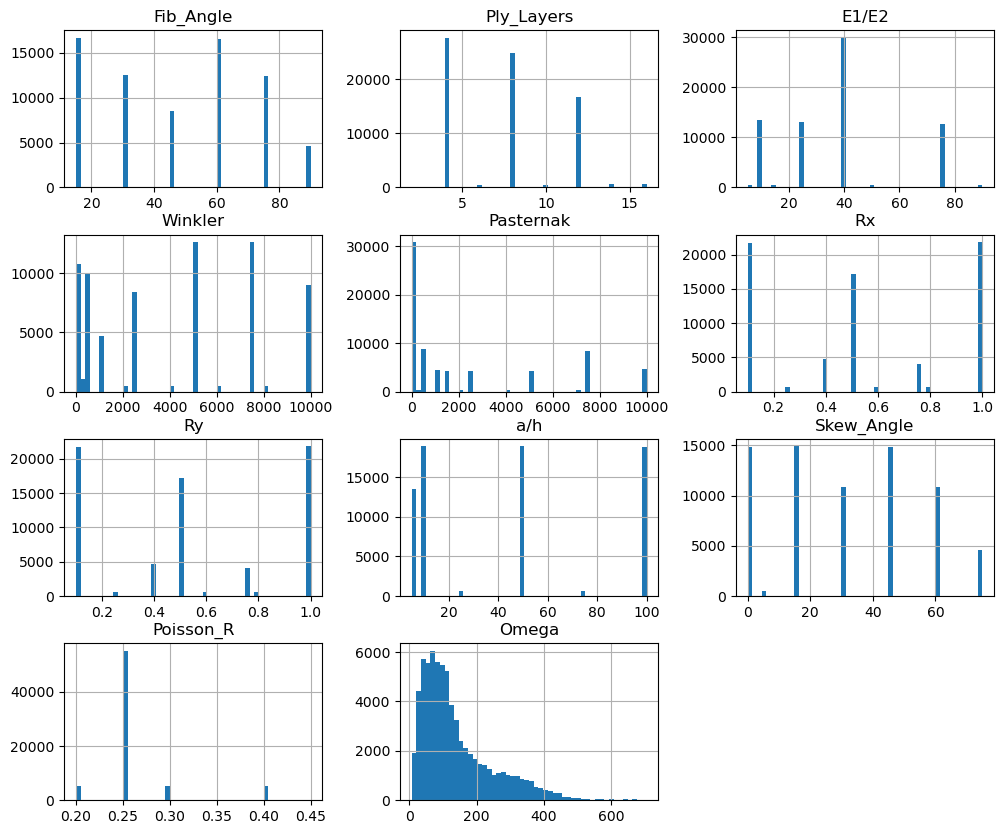

In [177]:
balanced_df.hist(bins = 50, figsize = (12,10))
plt.show()

In [178]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(balanced_df, train_size=0.8, stratify=balanced_df['Strat_cat'])

In [179]:
X_train = train_df.iloc[:, 0:10]
y_train = train_df.iloc[:, 10]

X_test = test_df[test_df['Omega']<500].iloc[:, 0:10]
y_test = test_df[test_df['Omega']<500].iloc[:, 10]


In [180]:
y_log = np.log1p(y_train)
y_log_centered = y_log - y_log.mean()
y = np.expm1(y_log)


In [181]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MAE": f"{mean_absolute_error(y_true, y_pred):.3f}",
        "RMSE": f"{root_mean_squared_error(y_true, y_pred):.3f}",
    }

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern


In [111]:
rndm_frst = RandomForestRegressor(random_state=42)

# kernel = WhiteKernel(noise_level=0.6) + 1.0 * Matern(length_scale=10, nu = 1.5)
# gpr = GaussianProcessRegressor(
#         kernel= kernel, 
#         n_restarts_optimizer=10)


pipe = Pipeline([
    ('quantile_transform', QuantileTransformer(output_distribution='normal')),
    ('regressor', rndm_frst),
])

# model = TransformedTargetRegressor(
#         regressor=pipe,
#         func=np.log1p, 
#         inverse_func=np.expm1
#         )

pipe.fit(X_train, y_log_centered)


Pipeline(steps=[('quantile_transform',
                 QuantileTransformer(output_distribution='normal')),
                ('regressor', RandomForestRegressor(random_state=42))])

In [112]:
y_pred = pipe.predict(X_test)
y_pred = np.expm1(y_pred + y_log.mean())
compute_score(y_test, y_pred)


{'R2': '0.986', 'MAE': '6.194', 'RMSE': '11.294'}

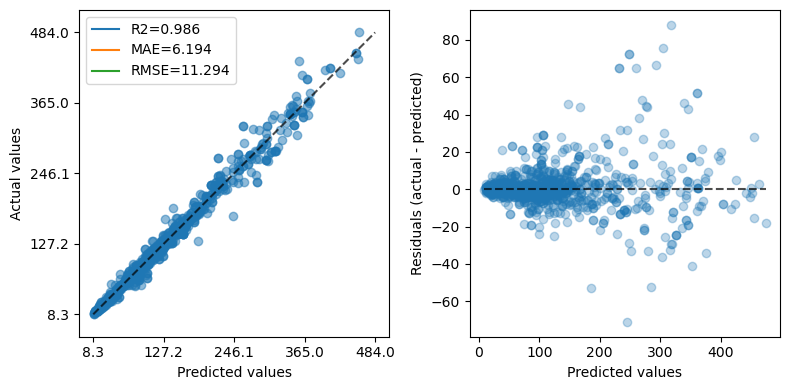

In [113]:
from sklearn.metrics import PredictionErrorDisplay

from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


f, (ax0) = plt.subplots(1, 2, sharey=False, figsize=(8, 4))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0]], [y_pred]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], label=f"{name}={score}")
    ax.legend(loc="upper left")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.3},
)

# f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()
plt.show()

In [84]:
list = ['Fib_Angle',
 'Ply_Layers',
 'E1/E2',
 'Winkler',
 'Pasternak',
 'Rx',
 'Ry',
 'a/h',
 'Skew_Angle',
 'Poisson_R']


In [85]:
len(list)


10

In [109]:
problem = {
    'num_vars': 10,
    'names': ['Fib_Angle', 'Ply_Layers', 'E1/E2', 'Winkler', 'Pasternak', 'Rx', 'Ry', 'a/h', 'Skew_Angle', 'Poisson_R'],
    'bounds': [[0,1]]*10
}


In [115]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# Generate Saltelli samples (handles calc_second_order automatically)
N = 4096  # Base sample count (actual samples = N * (2D + 2))
X_mc = saltelli.sample(problem, N, calc_second_order=True)
X_mc_df = pd.DataFrame(X_mc, columns=problem["names"])

# Predict with Kriging
y_mc_mean = pipe.predict(X_mc_df)
y_pred_mc = np.expm1(y_mc_mean + y_log.mean())

# Compute Sobol indices (now calc_second_order=True)
Si = sobol.analyze(
    problem,
    y_pred_mc,
    calc_second_order=True,  # Must match sampling!
    print_to_console=True
)

# Print results
print("First-order indices:", Si['S1'])
print("Total-order indices:", Si['ST'])

C:\Users\Sabyasachi\AppData\Local\Temp\ipykernel_16324\195985107.py:6: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X_mc = saltelli.sample(problem, N, calc_second_order=True)
c:\Users\Sabyasachi\.conda\envs\DSML\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                  ST   ST_conf
Fib_Angle   0.000000  0.000000
Ply_Layers  0.000000  0.000000
E1/E2       0.000000  0.000000
Winkler     0.000000  0.000000
Pasternak   0.000000  0.000000
Rx          0.257548  0.016760
Ry          0.738213  0.029502
a/h         0.000000  0.000000
Skew_Angle  0.000000  0.000000
Poisson_R   0.000000  0.000000
                  S1   S1_conf
Fib_Angle   0.000000  0.000000
Ply_Layers  0.000000  0.000000
E1/E2       0.000000  0.000000
Winkler     0.000000  0.000000
Pasternak   0.000000  0.000000
Rx          0.257547  0.026473
Ry          0.738717  0.041950
a/h         0.000000  0.000000
Skew_Angle  0.000000  0.000000
Poisson_R   0.000000  0.000000
                                    S2       S2_conf
(Fib_Angle, Ply_Layers)   0.000000e+00  0.000000e+00
(Fib_Angle, E1/E2)        0.000000e+00  0.000000e+00
(Fib_Angle, Winkler)      0.000000e+00  0.000000e+00
(Fib_Angle, Pasternak)    0.000000e+00  0.000000e+00
(Fib_Angle, Rx)           0.000000e+00  1.865337e-17


C:\Users\Sabyasachi\AppData\Local\Temp\ipykernel_16324\1360330931.py:43: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X_sobol = saltelli.sample(problem, N, calc_second_order=True)
c:\Users\Sabyasachi\.conda\envs\DSML\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


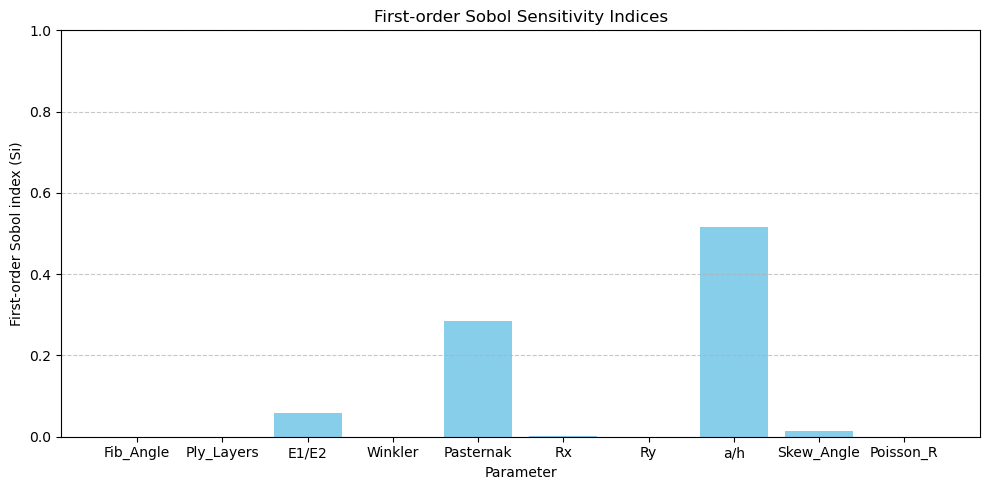

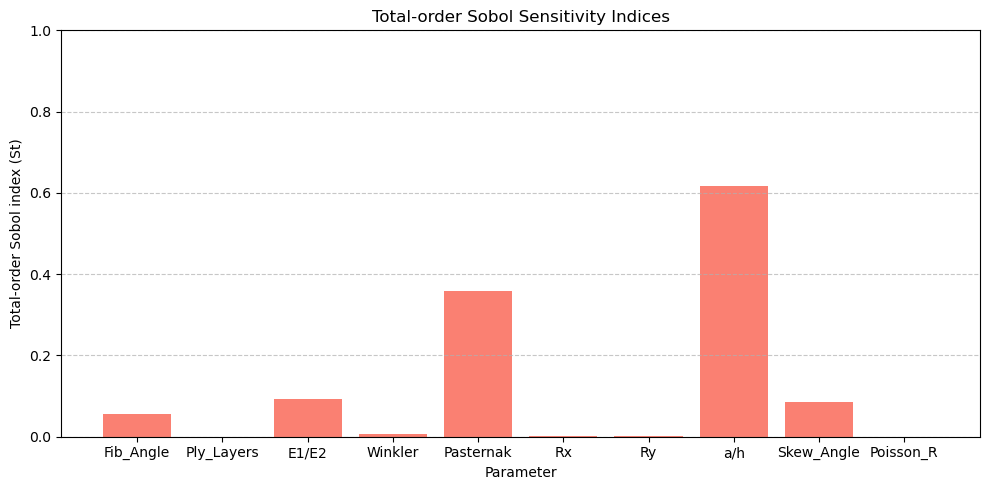

In [190]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv('balanced_df_sph.csv')
df = balanced_df

# Remove constant or near-constant columns
feature_names = [c for c in ['Fib_Angle','Ply_Layers','E1/E2','Winkler','Pasternak','Rx','Ry','a/h','Skew_Angle','Poisson_R']
                 if df[c].nunique() > 1 and not (df[c].std() < 1e-8)]

# Train/test split
train_df, test_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['Strat_cat'])
X_train = train_df[feature_names]
y_train = train_df['Omega']

# Fit pipeline
y_log = np.log1p(y_train)
y_log_centered = y_log - y_log.mean()
pipe = Pipeline([
    ('quantile', QuantileTransformer(output_distribution='normal', random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_estimators=200))
])
pipe.fit(X_train, y_log_centered)

# Set Sobol bounds to training data range
bounds = [[X_train[c].min(), X_train[c].max()] for c in feature_names]
problem = {
    'num_vars': len(feature_names),
    'names': feature_names,
    'bounds': bounds
}

# Saltelli sampling
N = 1024
X_sobol = saltelli.sample(problem, N, calc_second_order=True)
X_sobol_df = pd.DataFrame(X_sobol, columns=feature_names)

# Predict and invert log transform
y_sobol_log_centered = pipe.predict(X_sobol_df)
y_sobol_pred = np.expm1(y_sobol_log_centered + y_log.mean())

# Sobol analysis
Si = sobol.analyze(problem, y_sobol_pred, calc_second_order=True)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(problem['names'], Si['S1'], color='skyblue')
plt.xlabel('Parameter')
plt.ylabel('First-order Sobol index (Si)')
plt.title('First-order Sobol Sensitivity Indices')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(problem['names'], Si['ST'], color='salmon')
plt.xlabel('Parameter')
plt.ylabel('Total-order Sobol index (St)')
plt.title('Total-order Sobol Sensitivity Indices')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
